<a href="https://colab.research.google.com/github/Cloblak/GeneralizingSentiment/blob/main/ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT, force_remount=False)

Mounted at /content/drive


In [6]:
!ls

drive  full_raw_data.parquet.gzip  sample_data


In [7]:
%cd /content/drive/"My Drive"/AIPI540_NLP/data

/content/drive/My Drive/AIPI540_NLP/data


In [34]:
import numpy as np
import pandas as pd
import pyarrow as pa
import string
import time
import urllib.request
import zipfile
import torch

from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier



import warnings
warnings.filterwarnings('ignore')



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
data = pd.read_parquet("full_raw_data.parquet.gzip")
print(data.count())

sentiment    39165
text         39165
dtype: int64


In [18]:
data.head()

,sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


Class positive: 7383
Class neutral: 9681
Class negative: 22101


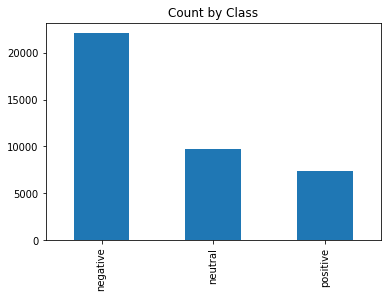

In [20]:
# summary of our image classes
target_count = data.sentiment.value_counts()
print('Class positive:', target_count["positive"])
print('Class neutral:', target_count["neutral"])
print('Class negative:', target_count["negative"])


target_count.plot(kind='bar', title='Count by Class');

In [27]:

X_train,X_test,y_train,y_test = train_test_split(data['text'].values.tolist(), data['sentiment'], random_state=0,test_size=0.2)

In [30]:
# Load pre-trained model
senttrans_model = SentenceTransformer('paraphrase-MiniLM-L6-v2',device=device)

# Create embeddings for training set text
#X_train = train_df['full_text'].values.tolist()
X_train = [senttrans_model.encode(doc) for doc in tqdm(X_train)]

# Create embeddings for test set text
#X_test = test_df['full_text'].values.tolist()
X_test = [senttrans_model.encode(doc) for doc in tqdm(X_test)]

100%|██████████| 7833/7833 [03:30<00:00, 37.24it/s]


In [31]:
# Train a classification model using logistic regression classifier
logreg_model = LogisticRegression(solver='saga')
logreg_model.fit(X_train,y_train)
preds = logreg_model.predict(X_train)
acc = sum(preds==y_train)/len(y_train)
print('Accuracy on the training set is {:.3f}'.format(acc))

Accuracy on the training set is 0.779


In [33]:
# Evaluate performance on the test set
preds = logreg_model.predict(X_test)
acc = sum(preds==y_test)/len(y_test)
print('Accuracy on the training set is {:.3f}'.format(acc))

Accuracy on the training set is 0.774


In [ ]:
# cross validation

In [35]:
X = np.r_[X_train, X_test]
y = np.r_[y_train, y_test]

In [40]:
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), X, y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50),verbose=5)

[learning_curve] Training set sizes: [  352  1064  1776  2488  3201  3913  4625  5337  6049  6761  7474  8186
  8898  9610 10322 11034 11746 12459 13171 13883 14595 15307 16019 16732
 17444 18156 18868 19580 20292 21004 21717 22429 23141 23853 24565 25277
 25990 26702 27414 28126 28838 29550 30262 30975 31687 32399 33111 33823
 34535 35248]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  97 out of 500 | elapsed:  1.1min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done 198 out of 500 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done 299 out of 500 | elapsed:  1.1min remaining:   45.3s
[Parallel(n_jobs=-1)]: Done 400 out of 500 | elapsed:  1.1min remaining:   16.9s


KeyboardInterrupt: ignored

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()  